In [2]:
# All imports 
import random
import math 
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

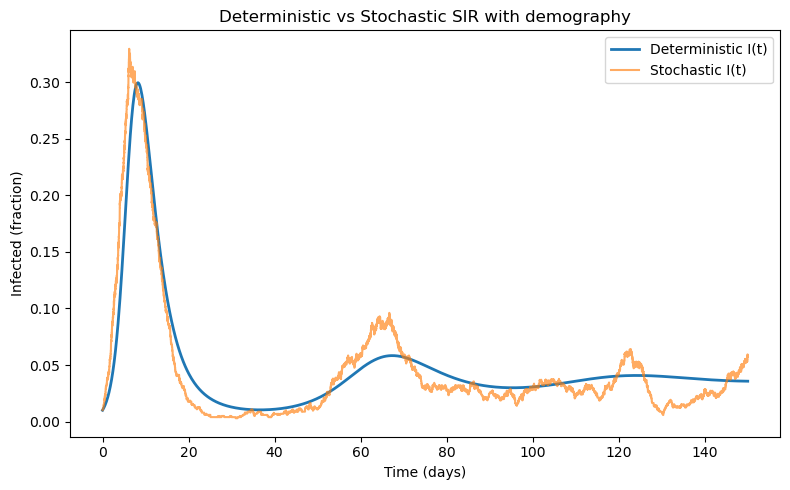

In [6]:
# Implement Gillespies (Direct) Algorithm 

# step 1: label all possible events 
EVENTS = {
    "birth":     (+1,  0,  0),  
    "infection": (-1, +1,  0),   
    "recovery":  ( 0, -1, +1),  
    "death_S":   (-1,  0,  0),   
    "death_I":   ( 0, -1,  0),   
    "death_R":   ( 0,  0, -1),   
}

def gillespie_sir(X0, Y0, Z0, beta, gamma, mu, T_max, seed=1):
    """Gillespie (direct method) for SIR with demography; returns times and X,Y,Z lists."""
    random.seed(seed)
    X, Y, Z = X0, Y0, Z0
    t = 0.0

    times = [t]
    X_list, Y_list, Z_list = [X], [Y], [Z]

    while True:
        N = X + Y + Z

        # step 2: define event rates R_m
        birth_rate      = mu * N
        infection_rate  = beta * X * Y / N if N > 0 else 0.0
        recovery_rate   = gamma * Y
        deathS_rate     = mu * X
        deathI_rate     = mu * Y
        deathR_rate     = mu * Z

        rates = [birth_rate, infection_rate, recovery_rate,
                 deathS_rate, deathI_rate, deathR_rate]
        names = ["birth", "infection", "recovery", "death_S", "death_I", "death_R"]

        # step 3: calculate the total rate
        R_total = sum(rates)
        if R_total <= 0.0:
            break  

        # step 4: set time until next event
        u1 = random.random()
        dt = -math.log(u1) / R_total

        # step 5: draw second random number and set P
        u2 = random.random()
        P = u2 * R_total

        # step 6: choose event p by cumulative rates an apply it 
        cumulative = 0.0
        event = None
        for k, r in enumerate(rates):
            cumulative += r
            if P <= cumulative:
                event = names[k]
                break

        # step 7; update time and states 
        dX, dY, dZ = EVENTS[event]
        X += dX; Y += dY; Z += dZ

        t += dt
        times.append(t)
        X_list.append(X)
        Y_list.append(Y)
        Z_list.append(Z)

        # step 8: return to step 2
        if t >= T_max:
            break
        if Y == 0 and infection_rate == 0.0:
            break

    return times, X_list, Y_list, Z_list

# Deterministic SIR
def sir_ode(y, t, beta, gamma, mu):
    S, I, R = y
    dSdt = mu - beta*S*I - mu*S
    dIdt = beta*S*I - (gamma + mu)*I
    dRdt = gamma*I - mu*R
    return [dSdt, dIdt, dRdt]

# Compare stochastic vs deterministic 
beta  = 1.0
gamma = 0.33
mu    = 1 / 50
T_max = 150

N0 = 1000
X0, Y0, Z0 = 990, 10, 0
y0 = [X0/N0, Y0/N0, Z0/N0]

# deterministic
t_det = np.linspace(0, T_max, 1000)
sol = odeint(sir_ode, y0, t_det, args=(beta, gamma, mu))
S_det, I_det, R_det = sol.T

# stochastic
t_sto, X_sto, Y_sto, Z_sto = gillespie_sir(X0, Y0, Z0, beta, gamma, mu, T_max)

# convert counts into fractions for comparison 
I_sto_frac = [i/(x+i+z) for x, i, z in zip(X_sto, Y_sto, Z_sto)]

# plot I(t)
plt.figure(figsize=(8,5))
plt.plot(t_det, I_det, lw=2, label='Deterministic I(t)')
plt.step(t_sto, I_sto_frac, where='post', alpha=0.65, label='Stochastic I(t)')
plt.xlabel('Time (days)'); plt.ylabel('Infected (fraction)')
plt.title('Deterministic vs Stochastic SIR with demography')
plt.legend(); plt.tight_layout(); plt.show()




In [16]:
# Investigate Simulation Variability and Negative Co-variance